In [1]:
%matplotlib inline
from pylab import *
from numpy import *
import neuron
import pyNN
from pyNN import neuron
from pyNN.standardmodels import electrodes, build_translations, StandardCurrentSource
from pyNN.parameters import ParameterSpace, Sequence
from pyNN.neuron import simulator
from pyNN.utility import get_simulator, normalized_filename
from pyNN.utility.plotting import Figure, Panel
from neuron import h
from quantities import mV,Hz, s ,ms
import elephant as ep
import elephant.kernels as kernels
from elephant.spike_train_generation import threshold_detection
from elephant.spike_train_dissimilarity import victor_purpura_dist
from elephant.spike_train_dissimilarity import van_rossum_dist
import seaborn as sns
import neo
import quantities as pq
import numpy as np
from scipy.optimize import minimize, fmin
from sklearn import preprocessing
from operator import add

In [2]:
def optimize(*args):
#The function, optimize as defined below is used to find the neuron, given the parameters chosen, that is most likely
#to produce similar if not the same results for spikes. Given the use of distance functions to determine similarity
#between neurons, where 0 is the most similar, all values are mapped or normalized such that the ideal score, is 0 
#or as clost to 0. The scoring works in such as way that we add up the values given by the mapping of the correlation
#coefficient, and the distance determined by victor_prupura and van_rossum. Given the statement of 0 being the most
#desired value, the correlation coefficient is mapped such that the highest correlation, 1 becomes 0, and the lowest
#correlation is mapped to what would be the highest value. Then, given the distance matrices determined by the methods
#noted above, the scores are normalized such that the highest value in each array of the x-by-x matrix of distance is
#determined to be 1, and the lowest value 0, scaling all values in between. The values are then summed element-wise,
#whereby, the optimal solution is 0 or nearly 0 and the worst solution is at most 3. The array is turned into a list
#to remove the target so as to ensure the target can never be picked. Then the min() command is used to determine the
#lowest value, bar the target itself. This allows us to then determine the neuron, its score and its v-thresh.

#def optimize(a, b, c, d, e, f, g, h, i, j, k, l, m)
#a is start of linspace for voltage threshhold of the cell
#b is the end of the linspace
#c is the number of steps
#d is the start time for the source current
#e is the end time for the current
#f is the amplitude of the current
#g is the the offset
#h is the frequency 
#i is the phase
#d-i would come as the followingL
#start = 20.0, stop = 80.0, amplitude = -10, offset = 0.1, frequency = 10, phase = 180.0
#j is the total run time for the model
#k is the target column of the voltage outputs given by the model
#l is the penalty value (hertz) for victor_purpura_dist function (distance function)
#m is the penalty value (time) for van_rossum_dist function (distance function)
    thresh = linspace(a, b, c)
    #amps = linspace()
    #print(thresh)
    cell = neuron.Population(c, neuron.IF_curr_exp(v_thresh = -50, tau_refrac = 5.0, tau_m = 10.0))
    for cell_id in arange(0,c,1):
        #print(cell_id)
        cell[cell_id:(cell_id+1)].set(v_thresh= thresh[cell_id])
        pulse = neuron.ACSource(start = d, stop = e, amplitude = f, offset = g, frequency = h, phase = i)
        cell[cell_id].inject(pulse)
        #for cell_id in arange(0,500):
            #pulse = neuron.ACSource(start = 20.0, stop = 80.0, amplitude = amps[cell_id], offset = 0.1, frequency = 10, phase = 180.0)
            #cell[cell_id].inject(pulse)
    cell.record('v')
    neuron.run(j)
    cell.get('v_thresh')
    vm = cell.get_data().segments[0].filter(name = "v")[0]
    Tvm = vm.T
    #transpose matrix, mentally just works better in my head 
    Tvmc = corrcoef(Tvm)
    targetTvmc = Tvmc[k,:]
    ttarget = lambda targetTvmci:(1-targetTvmci)/(1-targetTvmc.min())
    #maps values in the targeted correlation coefficient array so that 1, being the highest correlation is mapped to 0 
    #and 0 representing the lowest correlation is mapped to 1
    ttarget = np.vectorize(ttarget)
    true = ttarget(targetTvmc)
    #currently working to create a loop that would allow for the creation of a column vector for each column to be analyzed and compated
    savetxt('truetarget.txt', true)
    trains = {}
    for cell_id in arange(0,c):
        trains[cell_id] = threshold_detection(vm[:,cell_id], threshold=-56.00*mV, sign='above')
    distance_matrix1 = victor_purpura_dist(trains.values(), q=array(l) * Hz)
    distance_matrix_1 = np.asarray(distance_matrix1)
    d1_norm = preprocessing.normalize(distance_matrix_1, norm = 'max', copy = False)
    #normalizes the victor_purpura distance function output on the target array where the max is 1
    t1 = d1_norm[k,:]
    
    distance_matrix2 = van_rossum_dist(trains.values(), tau=array(m) * pq.ms, sort = True)
    distance_matrix_2 = np.asarray(distance_matrix2)
    d2_norm = preprocessing.normalize(distance_matrix_2, norm = 'max', copy = False)
    t2 = d2_norm[k,:]
    #normalizes the van_rossum distance function output on the target array where the max is 1
    
    ntot = true + t1 + t2
    #total score 
    print("The target is neuron",k, "with voltage threshhold", thresh[k], "mV and a score of", ntot[k])

    l_ntot = ntot.tolist()
    l_ntot.pop(k)
    #pops out the target from the total score array so that when determining the most optimal solution to obtain the
    #target, the target is not inadvertantly picked.
    opt_ntot = np.asarray(l_ntot)
    
    
    plt.plot(ntot, '--bo')
    plt.ylabel('some numbers')
    plt.xticks(range(c))
    plt.show()
    #plots the values from the scoring array
    sols = min(opt_ntot)
    for ii in range(len(ntot)):
        if (sols == ntot[ii]):
            print("The Optimal Neuron is",ii, "with a voltage threshold of", thresh[ii], "mV and a score of", ntot[ii])
    return 

[-80.         -79.5959596  -79.19191919 -78.78787879 -78.38383838
 -77.97979798 -77.57575758 -77.17171717 -76.76767677 -76.36363636
 -75.95959596 -75.55555556 -75.15151515 -74.74747475 -74.34343434
 -73.93939394 -73.53535354 -73.13131313 -72.72727273 -72.32323232
 -71.91919192 -71.51515152 -71.11111111 -70.70707071 -70.3030303
 -69.8989899  -69.49494949 -69.09090909 -68.68686869 -68.28282828
 -67.87878788 -67.47474747 -67.07070707 -66.66666667 -66.26262626
 -65.85858586 -65.45454545 -65.05050505 -64.64646465 -64.24242424
 -63.83838384 -63.43434343 -63.03030303 -62.62626263 -62.22222222
 -61.81818182 -61.41414141 -61.01010101 -60.60606061 -60.2020202
 -59.7979798  -59.39393939 -58.98989899 -58.58585859 -58.18181818
 -57.77777778 -57.37373737 -56.96969697 -56.56565657 -56.16161616
 -55.75757576 -55.35353535 -54.94949495 -54.54545455 -54.14141414
 -53.73737374 -53.33333333 -52.92929293 -52.52525253 -52.12121212
 -51.71717172 -51.31313131 -50.90909091 -50.50505051 -50.1010101
 -49.6969697 

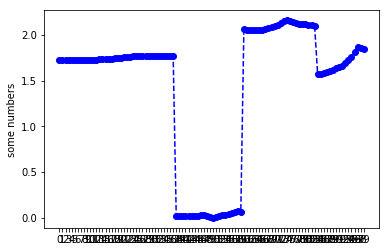

The Optimal Neuron is 49 with a voltage threshold of -60.2020202020202 mV and a score of 0.007394229725017229


In [3]:
a = -80
#a is start of linspace for voltage threshhold of the cell
b = -40
#b is the end of the linspace
c = 100
#c is the number of steps
d = 20
#d is the start time for the source current
e = 90
#e is the end time for the current
f = -5
#f is the amplitude of the current
g = .05
#g is the the offset
h = 15
#h is the frequency 
i = 180
#i is the phase
#d-i would come as the followingL
#start = 20.0, stop = 80.0, amplitude = -10, offset = 0.1, frequency = 10, phase = 180.0
j = 100.0
#j is the total run time for the model
k = 50
#k is the target column of the voltage outputs given by the model
l = 50.0
#l is the penalty value (hertz) for victor_purpura_dist function (distance function)
m = 10.0
#m is the penalty value (time) for van_rossum_dist function (distance function)

aa = [(a, b, c, d, e, f, g, h, i, j, k, l, m)]
isinstance(aa, list)
bb = np.asarray(aa)
optimize(*bb)

In [2]:
"Practice"

'Practice'

In [2]:
thresh = linspace(-70, -50, 10)
cell = neuron.Population(10, neuron.IF_curr_exp(v_thresh = -50, tau_refrac = 5.0, tau_m = 10.0))
for cell_id in arange(0,10,1):
    print(cell_id)
    cell[cell_id:(cell_id+1)].set(v_thresh= thresh[cell_id])
    pulse = neuron.ACSource(start = 20.0, stop = 80.0, amplitude = -10, offset = 0.1, frequency = 10, phase = 180.0)
    cell[cell_id].inject(pulse)
#for cell_id in arange(0,500):
#pulse = neuron.ACSource(start = 20.0, stop = 80.0, amplitude = amps[cell_id], offset = 0.1, frequency = 10, phase = 180.0)
    cell[cell_id].inject(pulse)
cell.record('v')
neuron.run(100.0)
vm = cell.get_data().segments[0].filter(name = "v")[0]

0
1
2
3
4
5
6
7
8
9


In [3]:
Tvm = vm.T
target = Tvm[3,:]
Tvmc = corrcoef(Tvm)
targetTvmc = Tvmc[3,:]
ttarget = lambda targetTvmci:(1-targetTvmci)/(1-targetTvmc.min())
ttarget = np.vectorize(ttarget)
true = ttarget(targetTvmc)

In [4]:
trains = {}
for cell_id in arange(10):
    trains[cell_id] = threshold_detection(vm[:, cell_id], threshold = -56.00*mV, sign = 'above')
for train in trains.values():
    if (len(train) > 0):
        print(train)

[25.775] ms
[25.775] ms
[25.775] ms
[25.775 32.725 39.    45.15  51.35  57.85  66.3  ] ms
[25.775 33.4   39.975 46.375 52.85  59.875] ms
[25.775 34.05  40.95  47.575 54.4   62.1  ] ms


In [5]:
distance_matrix1 = victor_purpura_dist(trains.values(), q=array(80.0) * Hz)
#print(distance_matrix1)
d1_norm = preprocessing.normalize(distance_matrix1)
#sns.heatmap(distance_matrix1)
#print(d1_norm)
t_d1 = d1_norm[3,:]

In [6]:
distance_matrix2 = van_rossum_dist(trains.values(), tau=array(10.0) * pq.ms, sort = True)
#sns.heatmap(distance_matrix2)
d2_norm = preprocessing.normalize(distance_matrix2)
#print(distance_matrix2)
#print(d2_norm)
t_d2 = d2_norm[3,:]

In [9]:
ntot = true + t_d1 + t_d2
#print("Total Scale")
#print(ntot)
l_ntot = ntot.tolist()
l_ntot.pop(3)
#print(l_ntot)
opt_ntot = np.asarray(l_ntot)
print("Total With Target:")
print(ntot)
print("Total W/O Target:")
print(opt_ntot)

Total With Target:
[1.22475766e+00 1.23305674e+00 1.22475766e+00 3.88787331e-16
 1.56287113e-02 4.27333102e-02 7.39937578e-02 1.39684273e+00
 1.27837843e+00 1.31051918e+00]
Total W/O Target:
[1.22475766 1.23305674 1.22475766 0.01562871 0.04273331 0.07399376
 1.39684273 1.27837843 1.31051918]


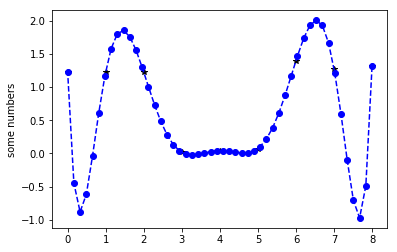

range(0, 8)

In [20]:
y = opt_ntot
x = arange(len(y))
z = np.polyfit(x, y, 8)
f = np.poly1d(z)
x_new = np.linspace(x[8], x[0], 50)
y_new = f(x_new)
plt.plot(x, y, 'k*', x_new, y_new, '--bo')
plt.ylabel('some numbers')
plt.show()

In [24]:
x = y = z = [None]
temp = opt_ntot
for i in range(len(opt_ntot)-1):
    if (opt_ntot[i]>temp[i+1]):
        temp +=1
        

In [7]:
a = [[1, 3, 4, 56, 9, 100],[1, 3, 4, 56, 9, 10]]
b = np.asarray(a)

In [8]:
norm = preprocessing.normalize(b, norm = 'max', copy = False)
print(norm)

[[0.01       0.03       0.04       0.56       0.09       1.        ]
 [0.01785714 0.05357143 0.07142857 1.         0.16071429 0.17857143]]
